In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.structural import UnobservedComponents
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import time
from scipy import stats

### We will use the same function from [Project 3](https://github.com/kennethwirjadisastra/Stat155/blob/main/Project3/RNN_model.ipynb) to set the seed for reproducability, as well as the device.

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True  # ensures deterministic algorithms
    torch.backends.cudnn.benchmark = False     # can slow down, but more reproducible

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### The WeatherRNN and TimeSeries classes will also remain the same.

In [3]:
class WeatherRNN(nn.Module):
  def __init__(self, input_size:int, hidden_size:int, output_size:int, num_layers:int=1, rnn_type:str='RNN', dropout:float=0.0):
    super().__init__()

    # potential RNN classes
    rnn_options = {"RNN": nn.RNN,
                   "LSTM": nn.LSTM,
                   "GRU": nn.GRU}

    if rnn_type not in rnn_options:
      raise ValueError(f'rnn_type must be one of {list(rnn_options.keys())}')

    # force dropout to be 0 if num_layers == 1
    dropout = dropout if num_layers > 1 else 0.0

    self.rnn_type = rnn_type

    # define the rnn
    self.rnn = rnn_options[rnn_type](input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

    # fully connected linear layers
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, h0=None):
    batch_size = x.size(0)
    out, _ = self.rnn(x) if h0 is None else self.rnn(x, h0)
    out = self.fc(out[:,-1,:])
    return out, _
  

class TimeSeries(Dataset):
  def __init__(self, data, seq_len):
    self.data = torch.tensor(data, dtype=torch.float32)
    self.seq_len = seq_len

  def __len__(self):
    # subtract self.seq_len to account for data where previous sequence is unknown
    return len(self.data) - self.seq_len

  def __getitem__(self, start_idx):
    end_idx = start_idx + self.seq_len

    # generate the sequence of size seq_len and the target that follows directly after
    X_seq = self.data[start_idx:end_idx].unsqueeze(-1) # (seq_len x 1)
    y = self.data[end_idx].unsqueeze(-1) # (1,)

    return X_seq, y

In [4]:
def read_data(stations):
    # create array to store each dataframe created
    df_dict = {}         # each value in df_dict will be an dictionary with values of pd.DataFrame objects
                         # the key of each dataframe determines the type of dataset as shown below

    dataset_types = {
        0: "train",      # first element
        1: "validation", # second element
        2: "test"        # third element
    }

    # recover necessary data from each csv file
    for station in stations:

        for j in dataset_types.keys():
            df = pd.read_csv(f'../Project1/{dataset_types[j]}_data/{station}_weather_{dataset_types[j]}.csv')

            df["DATE"] = pd.to_datetime(df["DATE"])
        
            df.set_index("DATE", inplace=True)
        
            df = pd.DataFrame(df["TMAX"])

            # add dataframe to array
            df_dict[station] = [df] if station not in df_dict.keys() else df_dict[station] + [df]

    return df_dict

### We will create functions to help us read and normalize the data, create a `TimeSeries` dataset from a `pd.DataFrame`, and create a `DataLoader` from the `TimeSeries` dataset.

In [5]:
def read_weather_data(path, col="TMAX"):
    # read data and format DATE column
    df = pd.read_csv(path)
    df["DATE"] = pd.to_datetime(df["DATE"])
    df.set_index("DATE", inplace=True)
    return pd.DataFrame(df[col])

def normalize(df, col, transformation):
    norm = transformation(df[col].values.reshape(-1,1))
    return norm

def to_dataset(data_norm, seq_len):
    dataset = TimeSeries(data_norm.values, seq_len=seq_len)
    return dataset

def to_loader(dataset, batch_size=32, shuffle=False, drop_last=True):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    return dataloader

### The training and testing loop for each model will remain the same as in [Project 3](https://github.com/kennethwirjadisastra/Stat155/blob/main/Project3/RNN_model.ipynb).

In [6]:
def train_RNN(model, train_dataloader, validation_dataloader, num_epochs=50, 
              criterion=nn.MSELoss(), optimizer=optim.Adam, eta=1.e-3, device=device, show=True):
    
    model = model.to(device)

    training_loss = np.empty(num_epochs) * np.nan
    validation_loss = np.empty(num_epochs) * np.nan

    optimizer = optimizer(model.parameters(), lr=eta)

    #print("Training ...")

    #start_time = time.time()

    for epoch in range(num_epochs):
        # training and validation loss for each epoch
        train_epoch_loss = 0
        validation_epoch_loss = 0

        # reset hidden state after each epoch
        hidden = None

        model.train()
        for x_batch, y_batch in train_dataloader:
            if hidden is not None:
                if model.rnn_type == "LSTM":
                    hidden = (hidden[0].detach(), hidden[1].detach())
                else:
                    hidden = hidden.detach()

            out, hidden = model(x_batch, hidden)
            loss = criterion(out, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()
        
        # average loss over each batch
        train_epoch_loss /= len(train_dataloader)

        # save losses for plotting later
        training_loss[epoch] = train_epoch_loss

        
        model.eval()
        # reset hidden state
        hidden = None
        with torch.no_grad():
            for x_batch, y_batch in validation_dataloader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                if hidden is not None:
                    if model.rnn_type == "LSTM":
                        hiden = (hidden[0].detach(), hidden[1].detach())
                    else:
                        hidden = hidden.detach()

                out, hidden = model(x_batch, hidden)
                loss = criterion(out, y_batch)
                validation_epoch_loss += loss.item()
            
            validation_epoch_loss /= len(validation_dataloader)
        
        validation_loss[epoch] = validation_epoch_loss

        if show and epoch % 10 == 9:
            print(f'Epoch {epoch+1}: \n\tTraining Loss = {train_epoch_loss}\n\tValidation Loss = {validation_epoch_loss}')

    #end_time = time.time()

    #print("Done!")
    #print(f'Total time (seconds): {end_time-start_time}')

    return training_loss, validation_loss



def train_member(train_dataset, val_dataset, hidden_size=16, model_type='RNN', num_epochs=30, seed=42, show=False):
    # seed ensures that model's initial weights are always the same
    set_seed(seed)
    model = WeatherRNN(input_size=1,
                       hidden_size=hidden_size,
                       output_size=1,
                       num_layers=1,
                       rnn_type=model_type)
    
    train_loader = to_loader(train_dataset)
    val_loader = to_loader(val_dataset)
    
    train_loss, val_loss = train_RNN(model, train_loader, val_loader, num_epochs=num_epochs, show=show)
    return model, train_loss, val_loss


def test_RNN(model, dataloader, seq_len, device=device):
    # returns normalized predictions
    
    # store predictions in an array
    predictions = np.empty([len(dataloader)+seq_len, 1])

    # first seq_len entries not available
    predictions[:seq_len] = np.nan

    model.eval()

    with torch.no_grad():
        idx = seq_len # indices [0:seq_len] do not have associated output values
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            
            # make prediction
            out, _ = model(x)

            # add prediction to array
            predictions[idx] = out.item()
            idx += 1

    return predictions

### Now we start the data generation process. We will create a function to insert `Nan` values into the original data. The proportion of missing data `p` is passed into the function as an argument.

In [7]:
def delete_data(df: pd.DataFrame | pd.Series, col: str, p: float, missing_seq_len: int=5,
                window: int = 3):
    
    max_seq_start_idx = len(df) - 1 - missing_seq_len if (len(df) - 1 - missing_seq_len) % missing_seq_len != window else len(df) - 1

    nrows = round(p*(len(df)//5)) # number of rows to remove

    col_index = df.columns.get_loc(col)    # column index as integer (for iloc)

    seq_idx_start_arr = np.arange(window, max_seq_start_idx, step=missing_seq_len)

    start_indices = np.random.choice(seq_idx_start_arr, size=nrows, replace=False)

    df_na = df.copy()
    

    for i in range(missing_seq_len):
        df_na.iloc[start_indices + i, col_index] = np.nan
    
    return df_na, start_indices

### We can also create functions for the imputation methods we want to use. Each method takes the column to impute and adds a new column at the end with the imputed data.

In [8]:
def kalman_smoother(df_na, indices, col="NORM", level='local linear trend', seasonal=None):
    df_imputed = df_na.copy()
    
    model = UnobservedComponents(df_imputed[col], level=level, seasonal=seasonal)
    res = model.fit()
    #smoothed = res.smoothed_state[0]
    smoothed_obs = res.get_prediction().predicted_mean

    # insert new column at the end (index = -1)
    df_imputed[f'{col}_KS'] = df_imputed[col]

    for i in range(5):
        df_imputed.iloc[indices+i, -1] = smoothed_obs[indices+i]

    return df_imputed

def unconditional_mean(df_na, indices, col="NORM"): # not used in experiments
    df_imputed = df_na.copy()

    # insert new column at the end (index = -1)
    df_imputed[f'[{col}]_UM"'] = df_imputed[col]

    df_imputed.iloc[indices, -1] = df_imputed[col].mean(skipna=True)

    return df_imputed

def linear_interpolate(df_na, indices, col="NORM"):
    df_imputed = df_na.copy()

    # indices is a dummy variable so that all imputation functions take the same arguments
    df_imputed[f'{col}_LI'] = df_imputed[col].interpolate()
    
    return df_imputed

def impute_rolling_mean(df_na, indices, col="NORM", window=3):
    df_imputed = df_na.copy()
    # indices is a dummy variable so that all imputation methods take same arguments
    impute_col = f'{col}_RM'
    df_imputed[impute_col] = df_imputed[col]
    impute_col_idx = df_imputed.columns.get_loc(impute_col) # for use in .iloc[]

    for idx, row in df_imputed.iterrows():
        temp = row[impute_col]
        
        if pd.isna(temp):
            pos = df_imputed.index.get_loc(idx) # position of current date
            prev_values = df_imputed.iloc[pos - window:pos, impute_col_idx]
            if not prev_values.empty:
                df_imputed.loc[idx, impute_col] = prev_values.mean()
    return df_imputed

### Now we can simulate the missing data and imputation. We create `ensemble_size` datasets for each $\langle\text{method}, p\rangle$ combination and store the results in a nested dictionary.

In [9]:
def simulate_data(ensemble_size, imputation_methods, percentages, seq_len, 
                  scaler=MinMaxScaler(), dataset_types=None):

    dataset_types = dataset_types = {
        0: "train",      # first element
        1: "validation", # second element
     } if dataset_types is None else dataset_types

    # store complete dictionary of datasets
    # each value is a dictionary holding the ensemble_size datasets of each percentage
    all_datasets = {}
    for method in imputation_methods:
        all_datasets[method] = {}
        for p in percentages:
            all_datasets[method][p] = {}
            for dtype in dataset_types.values():
                all_datasets[method][p][dtype] = []
    
    for i in range(len(dataset_types)):
        # train or validation data (or other if specified)
        dataset_type = dataset_types[i]

        for p in percentages:

            for n in range(ensemble_size):
                            
                path = f'../Project1/{dataset_type}_data/APA_weather_{dataset_type}.csv'
                df = read_weather_data(path)
                df["NORM"] = normalize(df, col="TMAX", transformation=scaler.fit_transform)
                
                if dataset_type == "test":
                    # no need to remove and impute data for test set
                    dataset =  to_dataset(df["NORM"], seq_len=seq_len)
                
                else:
                    # delete data and impute for non test data
                    df, indices = delete_data(df, "NORM", p=p)
                    df.to_csv(f'missing_data/missing_data{n+1}.csv', index=True)
                    for method in imputation_methods.keys():
                        df_imputed = imputation_methods[method](df, indices)
                        # save csv
                        df_imputed.to_csv(f'{method}_{dataset_type}_data/'+f'{p:.2f}'[2:]+f'_{method}_{dataset_type}{n+1}.csv', index=True)
                        dataset = to_dataset(df_imputed.iloc[:, -1], seq_len=seq_len)
                        all_datasets[method][p][dataset_type].append(dataset)
             
    return all_datasets

### With all of our functions defined, we can start creating and training our models. We will generate our data using $p\in\{0.1, 0.25, 0.4\}$ and imputing using Kalman Smoother, rolling mean, and linear interpolation.

In [10]:
# the model will take the previous 7 days of data
seq_len = 7

# we will generate 5 datasets for each (imputation_method, percentage) combination
ensemble_size = 15

# we will test three imputations methods
imputation_methods = {'KS': kalman_smoother,
                      'RM': impute_rolling_mean,
                      'LI': linear_interpolate}

# we will test 3 rates of missing data
percentages = [0.1, 0.25, 0.4]

scaler = MinMaxScaler()

warnings.filterwarnings('ignore')

# generate the datasets and store in a dictionary
datasets = simulate_data(ensemble_size, imputation_methods, percentages, seq_len, scaler=scaler)

## CAUTION: The following cell will run for a very long time

### We will be using the same model from [Project 3](https://github.com/kennethwirjadisastra/Stat155/blob/main/Project3/RNN_model.ipynb). We will store the models in a dictionary.

In [11]:
num_epochs = 30
hidden_size = 16
model_type = 'LSTM'

# store models in a dictionary
all_models = {}

# track loss for each model
# shape: (num methods, num percentages, ensemble size, num epochs, num dataset types)
loss = np.zeros([len(imputation_methods),
                 len(percentages),
                 ensemble_size,
                 num_epochs,
                 2])


num_models =  len(imputation_methods) * len(percentages) * ensemble_size

model_id = 1

print(f'Training {num_models} models')

start_time = time.time()

for m, method in enumerate(imputation_methods.keys()):
    for p_idx, p in enumerate(percentages):
        # generate key for dictionary
        # round p to the nearest hundredth, add method name
        key = f'{method}_' + f'{round(p,2):.2f}'[-2:]

        # initialize empty ensemble of models
        all_models[key] = []
        
        # pull data
        train_datasets = datasets[method][p]['train']
        validation_datasets = datasets[method][p]['validation']
        #test_datasets =datasets[method][p]['test']

        """
        # could not figure out parallel training
        set_seed(42)
        ensemble = [WeatherRNN(input_size=1,
                                hidden_size=hidden_size,
                                output_size=1,
                                num_layers=1,
                                rnn_type=model_type) 
                    for _ in range(ensemble_size)]
        
        # Parallel training
        results = Parallel(n_jobs=-1)(
            delayed(train_member)(ensemble[n], loaders[method][p]['train'][n], loaders[method][p]['validation'][n], num_epochs=num_epochs)
            for n in range(ensemble_size)
        )
        """

        # generate ensemble of models and their loss statistics
        ensemble = [train_member(train_datasets[n], 
                                 validation_datasets[n], 
                                 num_epochs=num_epochs) for n in range(ensemble_size)]


        for n, (model, train_loss, val_loss) in enumerate(ensemble):
            # track loss and add model ensemble to dictionary
            loss[m, p_idx, n, :, :] = np.stack((train_loss, val_loss), axis=1)
            all_models[key].append(model)

        print(f'{ensemble_size*model_id}/{num_models} models complete')
        model_id += 1

end_time = time.time()
print('Training done!')
print(f'Time Elapsed: {end_time-start_time:.3f}')

Training 135 models
15/135 models complete
30/135 models complete
45/135 models complete
60/135 models complete
75/135 models complete
90/135 models complete
105/135 models complete
120/135 models complete
135/135 models complete
Training done!
Time Elapsed: 1539.558


### Now we can save the models to avoid having to retrain them from scratch

In [12]:
for key, ensemble in all_models.items():
    for i, model in enumerate(ensemble):
        path = f"{key[:2]}_model/model{i}.pt"
        torch.save(model.state_dict(), path)

### Now we will load our test dataset and evaluate each model's performance. This dataset is complete i.e. there are no missing values, and no imputation was performed on the data.

In [13]:
test_data_path = "../Project1/test_data/APA_weather_test.csv"

# read the test dataset
df_test = read_weather_data(test_data_path)

# normalize the test dataset and store in another pd.Series
test_norm = pd.Series(normalize(df_test, "TMAX", transformation=scaler.fit_transform).squeeze(axis=1),
                    index=df_test.index,
                    name="Norm")

# remove unnecessary columns in df_test, rename "TMAX" to "True"
df_test = pd.DataFrame(df_test["TMAX"])
df_test.rename(columns={"TMAX": "True"}, inplace=True)

# print true and weather normalized data
pd.concat([df_test, test_norm], axis=1)

,True,Norm
DATE,,
2022-03-21,45.0,0.470588
2022-03-22,40.0,0.421569
2022-03-23,52.0,0.539216
2022-03-24,64.0,0.656863
2022-03-25,63.0,0.647059
...,...,...
2025-03-30,52.0,0.539216
2025-03-31,61.0,0.627451
2025-04-01,51.0,0.529412


In [14]:
test_dataset = to_dataset(test_norm, seq_len=seq_len)
test_loader = to_loader(test_dataset,batch_size=1)

for method in imputation_methods.keys():
    for p in percentages:    
        key = f'{method}_' + f'{round(p,2):.2f}'[-2:]
        
        for n in range(ensemble_size):
            # grab nth ensemble member of current (method, p) configuration
            model = all_models[key][n]
            
            # predict
            test_predictions = scaler.inverse_transform(test_RNN(model, test_loader, seq_len=seq_len))

            # insert predictions into df_test
            df_test[f'{key}_{n+1}'] = test_predictions

# remove initial values (which all have no prediction)            
df_test = df_test.iloc[seq_len:]
df_test.head()

,True,KS_10_1,KS_10_2,KS_10_3,KS_10_4,KS_10_5,KS_10_6,KS_10_7,KS_10_8,KS_10_9,...,LI_40_6,LI_40_7,LI_40_8,LI_40_9,LI_40_10,LI_40_11,LI_40_12,LI_40_13,LI_40_14,LI_40_15
DATE,,,,,,,,,,,,,,,,,,,,,
2022-03-28,75.0,69.524969,69.468757,69.043593,69.684530,69.662893,69.466751,69.283138,69.838796,69.251658,...,71.258826,70.422427,71.216116,70.758626,70.797640,71.115394,71.648411,70.626442,70.992694,70.395761
2022-03-29,54.0,72.669620,72.427272,72.131788,72.755435,72.483168,72.663200,72.339779,72.692893,72.290899,...,73.750264,73.087622,73.583073,73.254083,73.333885,73.228129,73.524161,73.139378,73.608395,72.635361
2022-03-30,45.0,58.777973,58.225750,58.053683,58.954697,58.635605,58.445329,58.364458,58.878318,58.065946,...,57.015196,56.897457,57.124800,56.448163,56.690255,56.574906,56.812475,56.512875,56.881771,56.411381
2022-03-31,60.0,56.114012,55.340774,55.048214,55.897423,55.323934,55.711987,55.256358,55.769556,55.110203,...,52.719043,52.754530,52.229562,51.711440,52.614637,51.709197,51.610317,52.087316,52.422890,51.675363
2022-04-01,56.0,66.446192,65.789192,65.377951,66.191940,65.898596,65.530952,65.638009,66.308895,65.273593,...,64.290796,64.528280,63.395005,62.889249,63.611806,63.937518,63.826497,63.254412,63.599707,63.152158


### We will evaluate the models based on the RMSE. This will give us an idea of how far off our predictions are from the true data.

In [16]:
# store all RMSE and biases in 3d numpy arrays to compute the mean and std

RMSE = np.zeros([len(imputation_methods),
                 len(percentages),
                 ensemble_size])

# initialize empty dataframe to store results of experiment
df_results =pd.DataFrame({'Method': [],
                          'p': [],
                          'RMSE': []})

num_p = len(percentages)

row_counter = 0

for m, method in enumerate(imputation_methods.keys()):
    for p_idx, p in enumerate(percentages):
        for n in range(ensemble_size):
            col = f'{method}_' + f'{round(p,2):.2f}'[-2:] + f'_{n+1}'

            # compute RMSE and signed bias
            RMSE[m, p_idx, n] = root_mean_squared_error(df_test['True'], df_test[col])

            
            #df_idx = n + p_idx*ensemble_size + m*ensemble_size*num_p
            # add results to the dataframe and increment row counter
            df_results.loc[row_counter] = [method, p, RMSE[m,p_idx,n]]
            row_counter += 1

df_results

,Method,p,RMSE
0,KS,0.1,9.553194
1,KS,0.1,9.459283
2,KS,0.1,9.411262
3,KS,0.1,9.550933
4,KS,0.1,9.490718
...,...,...,...
130,LI,0.4,9.427117
131,LI,0.4,9.465339
132,LI,0.4,9.405572
133,LI,0.4,9.444841


### Now we take the mean of the RMSE and biases, and store them in arrays

In [17]:
# shape: (num methods, num p, 2 (mean and stddev))
RMSE_stats = np.stack([RMSE.mean(axis=2), RMSE.std(axis=2)], axis=-1)

### Now we store these ensemble statistics in a dataframe

In [18]:
df_stats = pd.DataFrame({"Method": [],
                         "p": [],
                         "RMSE_mean": [],
                         "RMSE_std": []})

row_counter = 0

for m, method in enumerate(imputation_methods):
    for p_idx, p in enumerate(percentages):
        #idx = p_idx + m*num_methods

        # insert statistics into dataframe and increment row counter
        df_stats.loc[row_counter] = [method, p, 
                                     RMSE_stats[m,p_idx,0], RMSE_stats[m,p_idx,1]]
        
        row_counter += 1


df_stats.set_index(['Method', 'p'], inplace=True)
df_stats.T

Method           KS                            RM                      \
p              0.10      0.25      0.40      0.10      0.25      0.40   
RMSE_mean  9.484038  9.510291  9.460547  9.471378  9.485982  9.454379   
RMSE_std   0.046429  0.064320  0.045255  0.047945  0.061638  0.042068   

Method           LI                      
p              0.10      0.25      0.40  
RMSE_mean  9.458989  9.448365  9.428474  
RMSE_std   0.043631  0.042344  0.029319

### We can visualize the RMSE using a box plot to show their means and spread. Note that the sample size is quite small, so this may not be truly representative of the population statistics. Nevertheless, I think it's worth looking at.

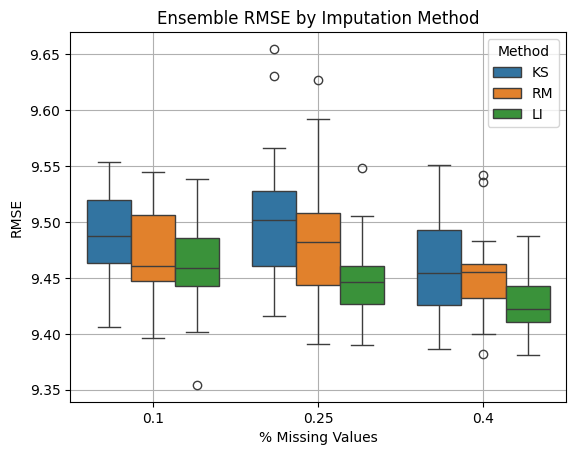

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1)

sns.boxplot(data=df_results, x='p', y='RMSE', hue='Method', ax=ax)
ax.set_title("Ensemble RMSE by Imputation Method")
ax.set_xlabel("% Missing Values")
ax.grid()

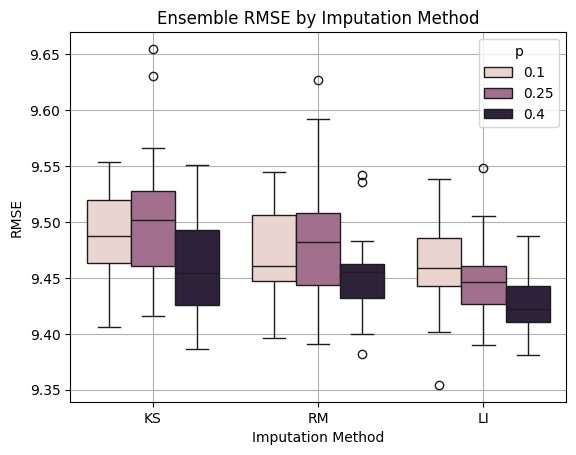

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1)

sns.boxplot(data=df_results, x='Method', y='RMSE', hue='p', ax=ax)
ax.set_title("Ensemble RMSE by % Missing Data")
ax.set_xlabel("Imputation Method")
ax.grid()

In [20]:
t_test_results = {'p': [],
                  't_stat': [],
                  'p_value': []}

df_results_KS_LI = pd.concat([df_results[df_results['Method']=='KS'], df_results[df_results['Method']=='LI']], axis=0)

for percent in percentages:
    df_results_percent = df_results_KS_LI[df_results_KS_LI['p']==percent]
    RMSE_by_percent = [group['RMSE'].values for _, group in df_results_percent.groupby('Method')]
    t_stat, p_value = stats.ttest_ind(*RMSE_by_percent, equal_var=False)
    t_test_results['p'].append(percent)
    t_test_results['t_stat'].append(t_stat)
    t_test_results['p_value'].append(p_value)

pd.DataFrame(t_test_results)

,p,t_stat,p_value
0,0.10,1.471048,0.152471
1,0.25,3.008883,0.006039
2,0.40,2.225548,0.035699


### Next we can plot the ensemble mean predictions of all 9 dataset configurations.

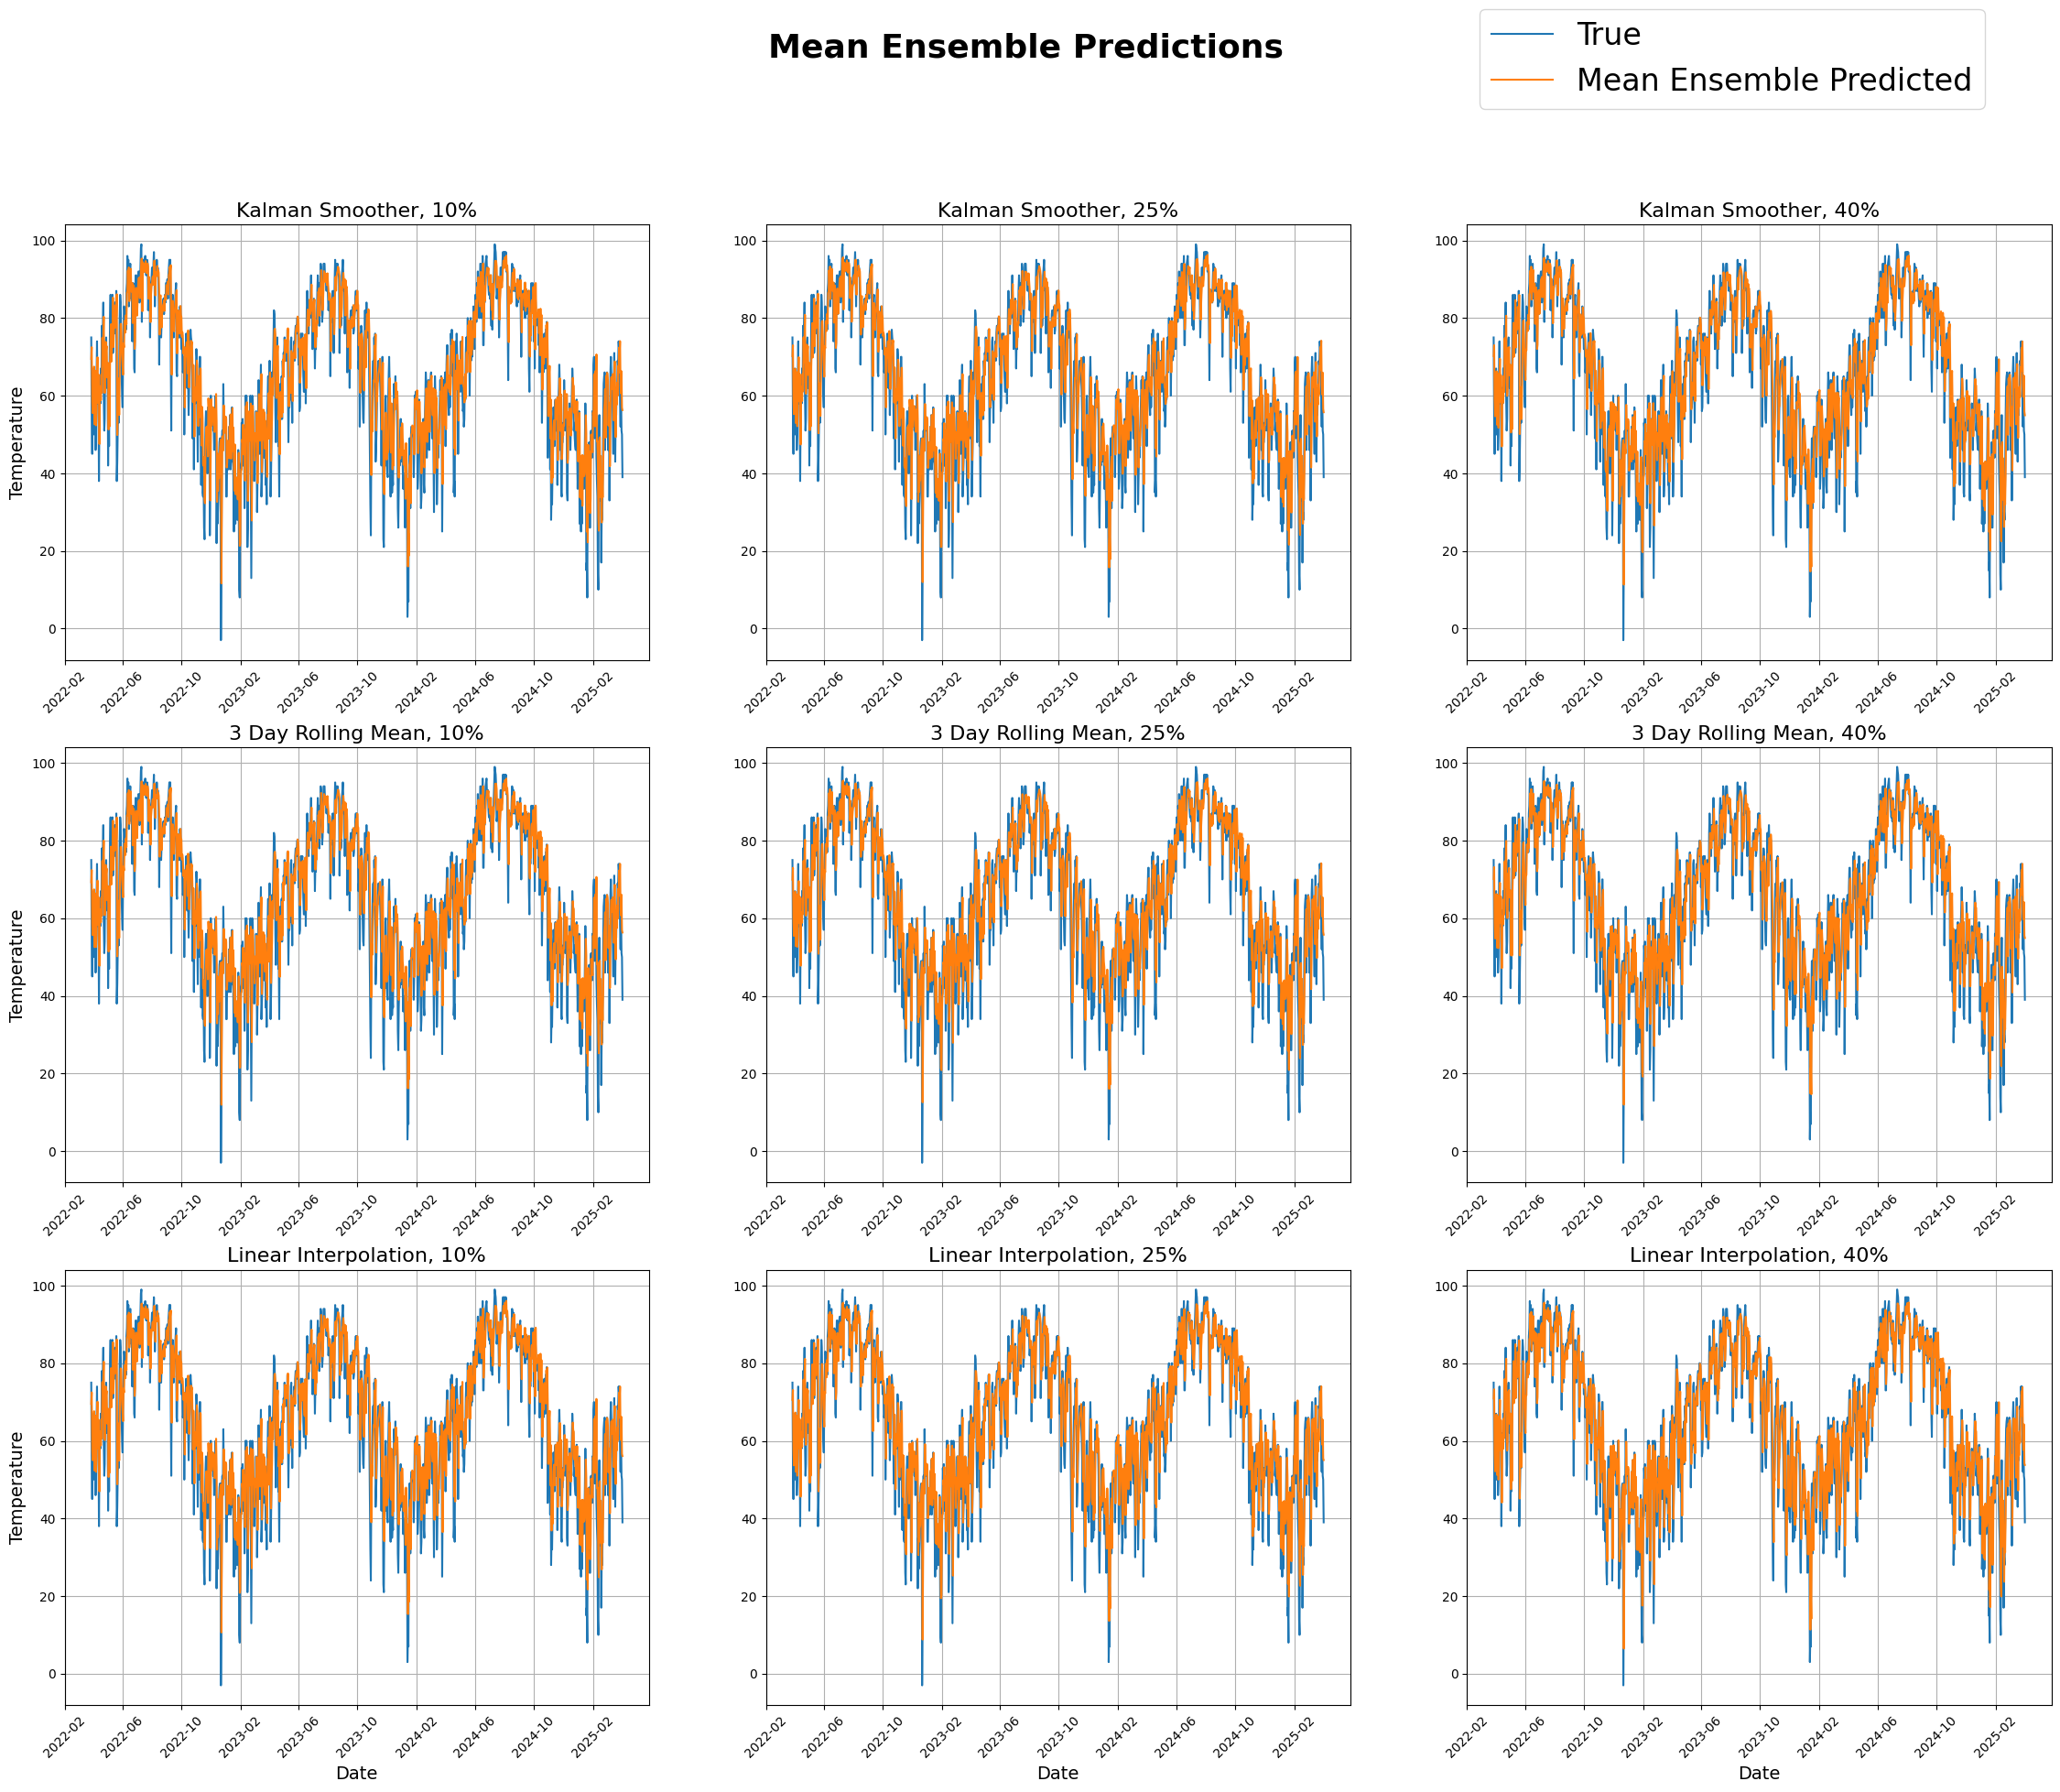

In [24]:
fig, ax = plt.subplots(nrows=len(imputation_methods), ncols=len(percentages), figsize=(28,21))

num_methods = len(imputation_methods)
num_p = len(percentages)

method_names  = {'KS': 'Kalman Smoother',
                 'RM': '3 Day Rolling Mean',
                 'LI': 'Linear Interpolation'}

for m, method in enumerate(imputation_methods):
    for p_idx, p in enumerate(percentages):
        col=f'{method}_'+f'{p:.2f}'[-2:]
        ax[m, p_idx].plot(df_test['True'], label='True')
        ax[m, p_idx].plot(df_test[[col+f'_{n+1}' for n in range(ensemble_size)]].mean(axis=1), label='Mean Ensemble Predicted')

        ax[m, p_idx].grid()
        ax[m, p_idx].set_title(f'{method_names[method]}, ' + f'{round(p, 2):.2f}'[-2:]+'%', fontsize=16)

        locator = mdates.MonthLocator(interval=4)
        formatter = mdates.DateFormatter('%Y-%m')  

        ax[m, p_idx].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
        ax[m, p_idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax[m, p_idx].tick_params(axis='x', rotation=45)


        if m == (len(imputation_methods) - 1):
            ax[m, p_idx].set_xlabel('Date', fontsize=14)

        if p_idx == 0:
            ax[m, p_idx].set_ylabel('Temperature', fontsize=14)

        #break
    #break
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.88,1), fontsize=24)
fig.suptitle('Mean Ensemble Predictions', fontweight='bold', fontsize=26)
plt.show()